In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split, learning_curve, validation_curve, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from imblearn.over_sampling import RandomOverSampler

In [2]:
def get_accuracy(model):

    print('-' * 80)
    print(f'\nMODEL: {model}\n')

    # Get sklearn accuracy score for given model; e.g., https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB.score
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    print(f'[*] Train Score: {str(train_score)}')
    print(f'[*] Test Score: {str(test_score)}')

    y_pred = model.predict(X_test)
    print('\n[*] Test Classification Report: \n', metrics.classification_report(y_test, y_pred))

    print('[*] Confusion Matrix on Test data')
    '''
    metrics.ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=list(range(2)), # length of unique values for label
    )
    '''
    cm = metrics.confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

    print(f'[*] Test Accuracy: {str(round(test_score, 5) * 100)}%')
    print('-' * 80 + '\n')

def select_optimal_model_parameters(default_model, gridsearch_model):
    """ Calculates accuracy for the default and Gridsearch nominated parameters and appends the model with the highest accuracy to the model evaluation list """
    # save for selection comparison against GridSearch nomination
    y_pred = default_model.predict(X_test)
    default_model_acc = metrics.accuracy_score(y_test, y_pred) *100

    y_pred = gridsearch_model.predict(X_test)
    gridsearch_model_acc = metrics.accuracy_score(y_test, y_pred) *100

    # Compare the default and GridSearch paramaters for highest accuracy model to append to evaluation list
    if default_model_acc >= gridsearch_model_acc:
        print('Default parameter model selected')
        models.append(default_model)
    else:
        print('Gridsearch parameter model selected')
        models.append(gridsearch_model)

In [3]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(figsize=(10, 6))
        
    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    
    # Extract mean and standard deviation from the learning curve results
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)


    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    axes.plot(train_sizes, train_scores_mean, label="Training score")
    axes.plot(train_sizes, test_scores_mean, label="Validation score")
    axes.set_title(title)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")
    axes.legend(loc="best")
    if ylim is not None:
        axes.set_ylim(*ylim)

def plot_validation_curve(estimator, X, y, param_name, param_range, cv=5, scoring="accuracy"):
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=-1
    )


    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)


    plt.figure(figsize=(10, 6))
    plt.title("Validation Curve")
    plt.xlabel(param_name)
    plt.ylabel(f"Score ({scoring})")
    plt.plot(param_range, train_scores_mean, label="Training score")
    plt.plot(param_range, test_scores_mean, label="Validation score")
    plt.legend(loc="best")
    plt.show()

In [4]:
models = []
# Load the dataset
file_path = "jobs_in_data.csv"
df = pd.read_csv(file_path)

# Convert 'salary_in_usd' to categories
df['salary_usd_group'] = pd.cut(
    df['salary_in_usd'],
    bins=[0, 50_000, 100_000, 200_000, 300_000, 400_000, 500_000],
    labels=['0-50K', '50k-100k', '100k-200k', '200k-300k', '300k-400k', '400k-500k']
)

# Encode categorical variables
le = LabelEncoder()
for column in df.select_dtypes(include=['object']).columns:
    df[column] = le.fit_transform(df[column])

# Separate features and target
X = df.drop(['salary'], axis=1)
X = X.drop(['salary_usd_group'],axis=1)
y = df['salary_usd_group']

y=le.fit_transform(y)

# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=['number']).columns.tolist()
categorical_features = X.select_dtypes(exclude=['number']).columns.tolist()

# Creating transformers for preprocessing
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Use ColumnTransformer to apply transformers to specific feature columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ],
    remainder='passthrough'
)

# Use RandomOverSampler to oversample minority classes
oversampler = RandomOverSampler(random_state=42)
X, y = oversampler.fit_resample(X, y)


Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96       355
           1       1.00      0.91      0.95       390
           2       0.96      0.95      0.96       399
           3       0.96      1.00      0.98       436
           4       1.00      1.00      1.00       399
           5       0.95      0.92      0.94       399

    accuracy                           0.96      2378
   macro avg       0.96      0.96      0.96      2378
weighted avg       0.96      0.96      0.96      2378

Confusion Matrix:
 [[355   0   0   0   0   0]
 [  0 356  16   0   0  18]
 [  0   0 381  18   0   0]
 [  0   0   0 434   2   0]
 [  0   0   0   0 399   0]
 [ 32   0   0   0   0 367]]


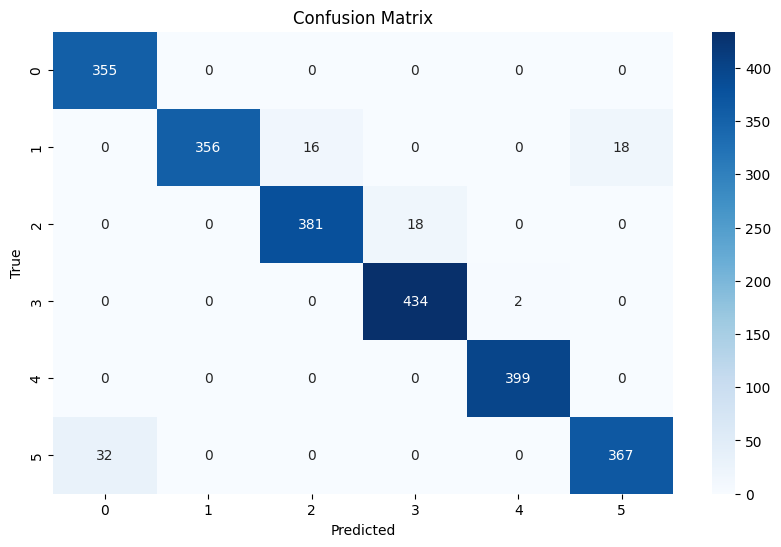

Cross-Validation Scores:  [0.89467045 0.99842321 0.98706625 0.96940063 0.93249211]
Mean CV Accuracy:  0.9564105303683718
Accuracy on Test Set: 0.9638
--------------------------------------------------------------------------------

MODEL: SVC()

[*] Train Score: 0.9600712483301173
[*] Test Score: 0.9638351555929352

[*] Test Classification Report: 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96       355
           1       1.00      0.91      0.95       390
           2       0.96      0.95      0.96       399
           3       0.96      1.00      0.98       436
           4       1.00      1.00      1.00       399
           5       0.95      0.92      0.94       399

    accuracy                           0.96      2378
   macro avg       0.96      0.96      0.96      2378
weighted avg       0.96      0.96      0.96      2378

[*] Confusion Matrix on Test data


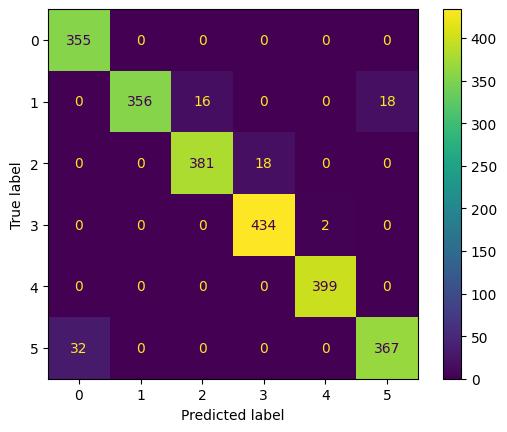

[*] Test Accuracy: 96.384%
--------------------------------------------------------------------------------



KeyboardInterrupt: 

In [5]:
import time
start_time = time.time()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=13)

#RBF Kernel
rbf_svm = SVC(kernel='rbf')
# print(X_train)
rbf_svm.fit(X_train,y_train)

# Make predictions on the test set
y_pred = rbf_svm.predict(X_test)

end_time = time.time()

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualization (consider using different plots for classification)
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', cmap='Blues', xticklabels=rbf_svm.classes_, yticklabels=rbf_svm.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Cross validation to validate the SVM model
cv_scores = cross_val_score(rbf_svm,X,y,cv=5,scoring="accuracy")

print("Cross-Validation Scores: ", cv_scores)
print("Mean CV Accuracy: ",np.mean(cv_scores))

# Fit the final model with the optimal max_depth
# optimal_max_depth = param_range[np.argmax(np.mean(test_scores, axis=1))]

final_clf = SVC(kernel='rbf',C=1,gamma="scale")
final_clf.fit(X_train, y_train)
# Evaluate on the test set
y_pred = final_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

print(f"Accuracy on Test Set: {accuracy:.4f}")
# print(f"F1 Score on Test Set: {f1:.4f}")

get_accuracy(rbf_svm)

# grid_values = {
#     'C': [0.1,1,10],
#     'kernel': ['linear','rbf','poly'],
#     'gamma': ['scale','auto',0.1,0.01]
# }

# # Instantiate and fit the GridSearch run
# grid_search = GridSearchCV(rbf_svm, param_grid=grid_values, cv=5, scoring='accuracy', n_jobs=-1).fit(X_train, y_train)
# grid_search.fit(X_train, y_train)
# clf_gs = grid_search.best_estimator_

# # Review the GridSearch nominated optimal model parameters
# grid_search.best_estimator_.get_params()

# get_accuracy(clf_gs)

# select_optimal_model_parameters(rbf_svm, clf_gs)

# total_time = end_time-start_time
# print(f"Total time taken : {total_time:.2f} seconds")

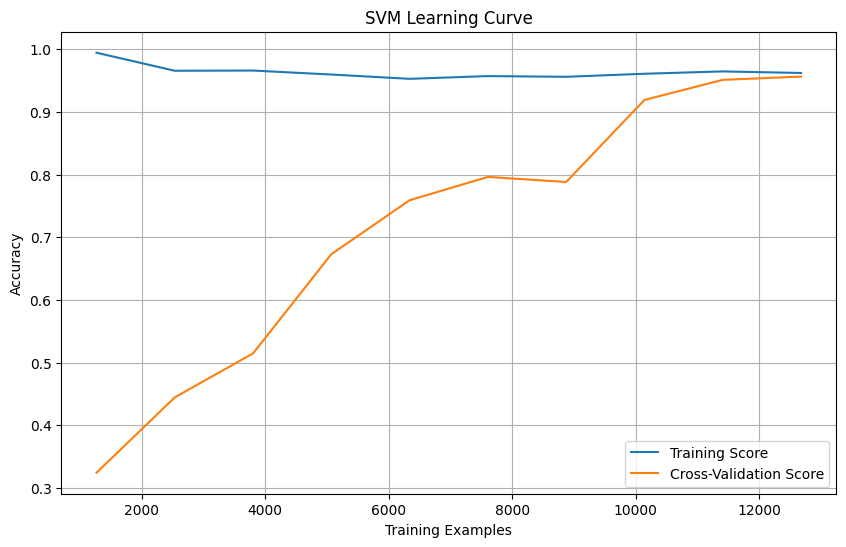

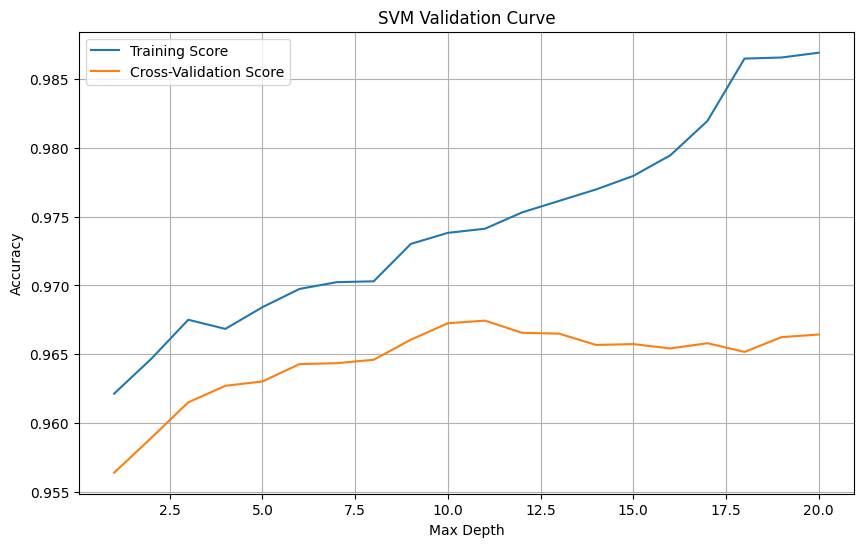

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
    rbf_svm, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy', n_jobs=-1
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-Validation Score')
plt.title('SVM Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Validation Curve
param_range = np.arange(1, 21)
train_scores, test_scores = validation_curve(rbf_svm, X, y, param_name="C", param_range=param_range, cv=5, scoring="accuracy", n_jobs=-1)

plt.figure(figsize=(10, 6))
plt.plot(param_range, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(param_range, np.mean(test_scores, axis=1), label='Cross-Validation Score')
plt.title('SVM Validation Curve')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)


--------------------------------------------------------------------------------

MODEL: SVC()

[*] Train Score: 0.9600712483301173
[*] Test Score: 0.9638351555929352

[*] Test Classification Report: 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96       355
           1       1.00      0.91      0.95       390
           2       0.96      0.95      0.96       399
           3       0.96      1.00      0.98       436
           4       1.00      1.00      1.00       399
           5       0.95      0.92      0.94       399

    accuracy                           0.96      2378
   macro avg       0.96      0.96      0.96      2378
weighted avg       0.96      0.96      0.96      2378

[*] Confusion Matrix on Test data


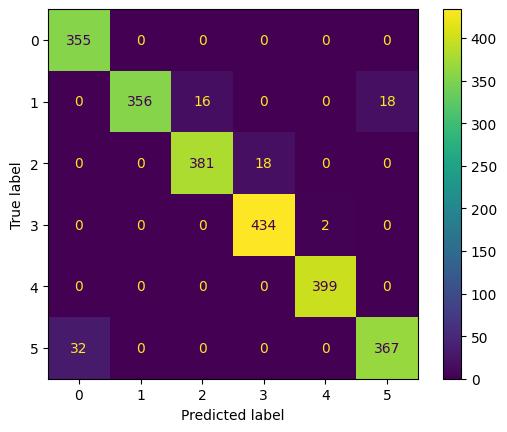

[*] Test Accuracy: 96.384%
--------------------------------------------------------------------------------

CPU times: total: 2.39 s
Wall time: 5.82 s


In [6]:
%%time

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=13)

rbf_svm = SVC(kernel='rbf')
rbf_svm.fit(X_train,y_train)

# Make predictions on the test set
get_accuracy(rbf_svm)

<Figure size 1000x600 with 0 Axes>

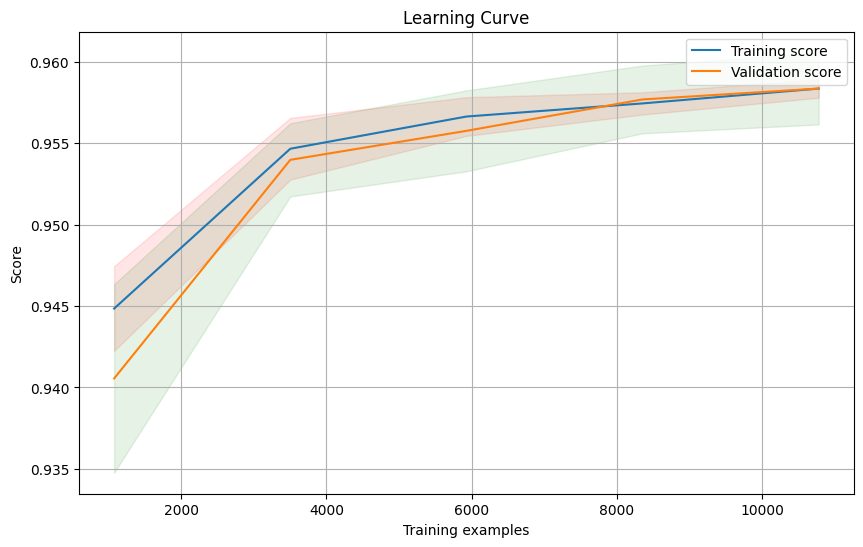

In [12]:
plt.figure(figsize=(10, 6))
plot_learning_curve(rbf_svm, "Learning Curve", X_train, y_train, cv=StratifiedKFold(n_splits=5))
plt.show()

# Plot the Validation curve
plot_validation_curve(rbf_svm,X_train, y_train,'C',param_range=param_range, cv=5, scoring="accuracy")

--------------------------------------------------------------------------------

MODEL: SVC(C=0.1, kernel='linear')

[*] Train Score: 0.999874229656647
[*] Test Score: 1.0

[*] Test Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00       806
           2       1.00      1.00      1.00       253
           3       1.00      1.00      1.00        26
           5       1.00      1.00      1.00       269

    accuracy                           1.00      1404
   macro avg       1.00      1.00      1.00      1404
weighted avg       1.00      1.00      1.00      1404

[*] Confusion Matrix on Test data


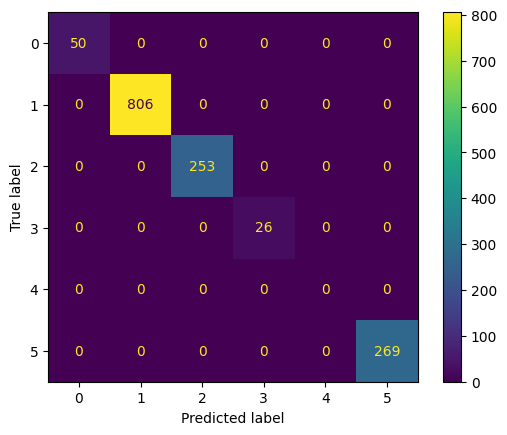

[*] Test Accuracy: 100.0%
--------------------------------------------------------------------------------

GridSearchCV Best Parameters:
{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
CPU times: total: 1.91 s
Wall time: 1min 57s


In [ ]:
%%time

grid_values = {
    'C': [0.1,1,10],
    'kernel': ['linear','rbf','poly'],
    'gamma': ['scale','auto',0.1,0.01]
}

# Instantiate and fit the GridSearch run
grid_search = GridSearchCV(rbf_svm, param_grid=grid_values, cv=5, scoring='accuracy', n_jobs=-1).fit(X_train, y_train)
grid_search.fit(X_train, y_train)
clf_gs = grid_search.best_estimator_

# Review the GridSearch nominated optimal model parameters
grid_search.best_estimator_.get_params()

get_accuracy(clf_gs)
# Additional details from GridSearchCV
print("GridSearchCV Best Parameters:")
print(grid_search.best_params_)

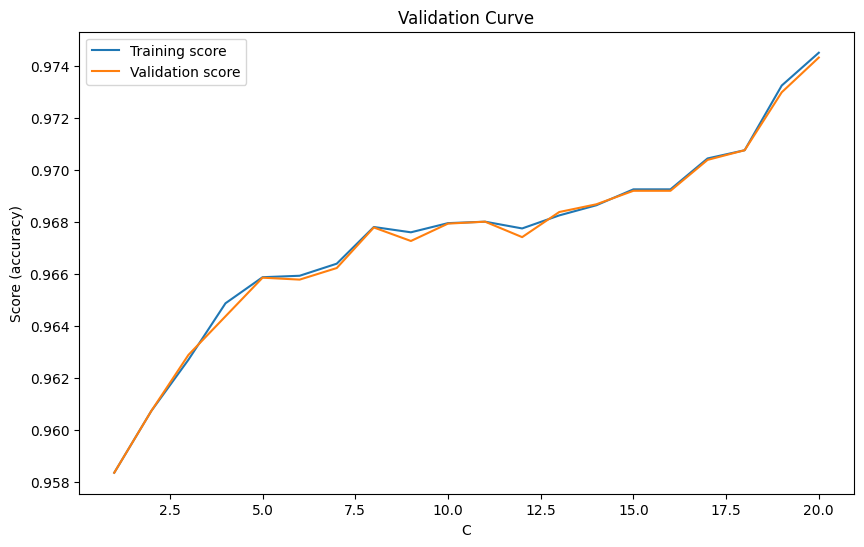

KeyboardInterrupt: 

In [9]:
param_range = np.arange(1, 21)
plot_validation_curve(rbf_svm,X_train, y_train,'C',param_range=param_range,  cv=5)


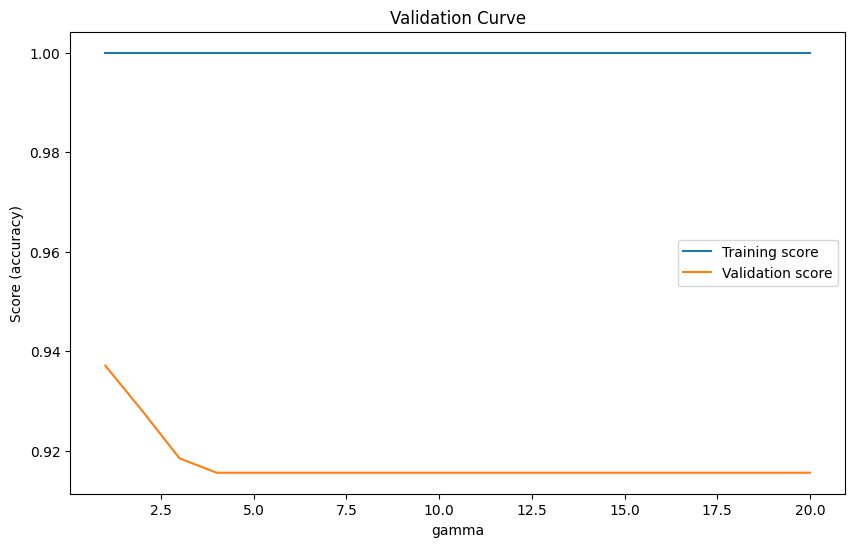

In [10]:
plot_validation_curve(rbf_svm,X_train, y_train,'gamma',param_range=param_range,  cv=5)